Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

C:\Users\KDossehAdjanon\Anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 199s 3ms/sample - loss: 0.2434 - val_loss: 0.1952
Epoch 2/10
60000/60000 [==============================] - 227s 4ms/sample - loss: 0.1926 - val_loss: 0.1898
Epoch 3/10
60000/60000 [==============================] - 209s 3ms/sample - loss: 0.1887 - val_loss: 0.1864
Epoch 4/10
60000/60000 [==============================] - 178s 3ms/sample - loss: 0.1862 - val_loss: 0.1852
Epoch 5/10
60000/60000 [==============================] - 180s 3ms/sample - loss: 0.1846 - val_loss: 0.1852
Epoch 6/10
60000/60000 [==============================] - 182s 3ms/sample - loss: 0.1832 - val_loss: 0.1832
Epoch 7/10
60000/60000 [==============================] - 176s 3ms/sample - loss: 0.1823 - val_loss: 0.1827
Epoch 8/10
60000/60000 [==============================] - 179s 3ms/sample - loss: 0.1815 - val_loss: 0.1818
Epoch 9/10
60000/60000 [==============================] - 186s 3ms/sample - loss: 0.1807 - val_loss: 0.1805
Epoch 10/10
60000/60000 [==============

C:\Users\KDossehAdjanon\Anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


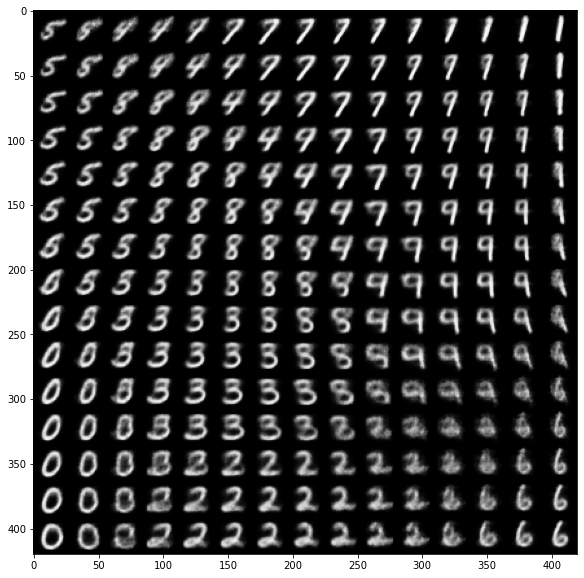

Complete: --- 1908.8551988601685 seconds has passed ---


In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np
from pathlib import Path
import time
start_time = time.time()
# Needed the following as caused CUDA DNN errors
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

#results_dir = Path('C:/Users/aland/class/DSC650/dsc650/dsc650/assignments/assignment12/').joinpath('results').joinpath('vae')
#results_dir.mkdir(parents=True, exist_ok=True)

img_shape = (28,28, 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding ='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding = 'same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding = 'same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding = 'same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)


class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([input_img, z_decoded])


from keras.datasets import mnist
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

import matplotlib.pyplot as plt
from scipy.stats import norm
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
print("grid_x")
print(grid_x)
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
print("grid_y")
print(grid_y)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
#img_file = results_dir.joinpath('Assignment_12_15x15_Grid.png')
#plt.savefig(img_file)
plt.show()

print("Complete: --- %s seconds has passed ---" % (time.time() - start_time))